In [32]:
%%writefile caber.py
import os
from shutil import copyfile
import pims
import PIL
import IPython.display as Disp
import cv2
import matplotlib.pyplot as plt
import ipywidgets as widgets
import numpy as np
from skimage import color
from skimage.filters import threshold_mean
import scipy
import pandas as pd
import lmfit
from matplotlib import animation, rc
import matplotlib
import IPython


def set_experiment_folder(exp_folder,video_file_name, video_path='./'):
    '''
    video_file_name : path to video file to be analyzed
    exp_folder : name for the folder to be created in the current folder and original video file copied to it
    
    '''
    
    try:
    
        os.makedirs(exp_folder)
        copyfile(f'{video_path}/{video_file_name}', f'{exp_folder}/{video_file_name}')

    except FileExistsError:
        print('File already exists')

def rotate_kronos_video(video_path, rotated_name_suffix='_rotated'):
    os.system(''.join(['ffmpeg -i "',
                       video_path,
                       '" -metadata:s:v rotate="270" -codec copy "',
                       video_path.split('.')[0], 
                       rotated_name_suffix,
                       '.',
                       video_path.split('.')[-1],
                       '"']))
    return video_path.split('.')[0] + rotated_name_suffix + '.' + video_path.split('.')[-1]

def check_framerate(video):
    display(PIL.Image.fromarray(video[0][:,:40]).rotate(90, expand=True))
    
    
class bbox_select():
     


    def __init__(self,im):
        self.im = im
        self.selected_points = []
        self.fig,ax = plt.subplots()
        self.img = ax.imshow(self.im.copy())
        self.ka = self.fig.canvas.mpl_connect('button_press_event', self.onclick)
        disconnect_button = widgets.Button(description="Disconnect mpl")
        Disp.display(disconnect_button)
        disconnect_button.on_click(self.disconnect_mpl)


        
    def poly_img(self,img,pts):
        pts = np.array(pts, np.int32)
        pts = pts.reshape((-1,1,2))
        cv2.polylines(img,[pts],True,(np.random.randint(0,255),np.random.randint(0,255),np.random.randint(0,255)),7)
        return img

    def onclick(self, event):
    #display(str(event))
        self.selected_points.append([event.xdata,event.ydata])
        if len(self.selected_points)>1:
            self.fig
            self.img.set_data(self.poly_img(self.im.copy(),self.selected_points))
    def disconnect_mpl(self,_):
        self.fig.canvas.mpl_disconnect(self.ka)

        
def get_mask_from_poly(bs):
    arr = np.array([bs.selected_points],'int')
    minx=min([item[0] for item in arr[0]])
    miny=min([item[1] for item in arr[0]])
    maxx=max([item[0] for item in arr[0]])
    maxy=max([item[1] for item in arr[0]])
    mask=(slice(miny,maxy),slice(minx,maxx)) 

    return mask

def find_thresh(video,frame, mask):
    ref_im=color.rgb2gray(video[-3][mask])
    thresh=threshold_mean(ref_im)
    return thresh

def measure_neck(video, thresh, mask, pb=None, strike_time=0.2,mmperpix=1,frame_rate=1,save_excel=False):
    
    pb=widgets.IntProgress(description="",min=0,max=3000,value=0,layout=widgets.Layout(width='50%'))
    pb.max=len(video)-3
    pb.description=video.filename
    display(pb)         
         
    frame_list=[]
    neck_profile_list=[]
    binary_list=[]
    neck_radius_list=[]
    min_neck_y_pos_list=[]
    mid_neck_radius_list=[]
    
    neck_radius_previous=400
    for i in range(1,len(video)-4):
        
        pb.value=i

        #analyze single frame for neck radius and consecutive frame variation to determine strike time
        im=color.rgb2gray(video[i][mask])
        
        binary = scipy.ndimage.morphology.binary_fill_holes(im < thresh)
        
        neck_profile=binary.sum(1)
        
        
        neck_radius=min(neck_profile)/2
        min_neck_y_pos=np.argmin(neck_profile)
        mid_neck_radius=neck_profile[int(len(neck_profile)/2)]/2
        
        if neck_radius_previous +50 <neck_radius:
            print(f'{neck_radius_previous} < {neck_radius} + 50')
            
            break
        neck_radius_previous=neck_radius
        
        binary_list.append(binary)
        neck_profile_list.append(neck_profile)
        neck_radius_list.append(neck_radius)
        frame_list.append(i)
        min_neck_y_pos_list.append(min_neck_y_pos)
        mid_neck_radius_list.append(mid_neck_radius)
    
    result=pd.DataFrame.from_dict({'frame':frame_list,
                                   'binary':binary_list,
                                   'neck_profile':neck_profile_list,
                                   'neck_radius':neck_radius_list,
                                   'min_neck_y_pos': min_neck_y_pos_list,
                                   'mid_neck_radius': mid_neck_radius_list})
    
    frame_strike_start=sum(map(lambda x: x>150, neck_radius_list))
    frame_strike_end=frame_strike_start+strike_time*frame_rate
    
    try:
        frame_breakup=min(result['neck_radius'][result['neck_radius']==0].index.tolist())
        print(frame_breakup)
    except:
        print('No breackup detected')
        frame_breakup=None
    
    t_strike_start=frame_strike_start/frame_rate
    t_strike_end=frame_strike_end/frame_rate
    
    if frame_breakup is not None:
        t_breakup=frame_breakup/frame_rate
    else:
        t_breakup=None
    
    result['time']=result['frame']/frame_rate
    result['neck_radius_mm']=result['neck_radius']*mmperpix
    result['time_exp']=(result['frame']-frame_strike_start)/frame_rate
    result['time_after_strike']=(result['frame']-frame_strike_end)/frame_rate
    result['strike_len_s']=t_strike_end-t_strike_start
    
    return result


def make_plot(result, fit_relax=False, min_radius=0.1, ax=None, model=None):
    
    if ax is None:
        fig, ax = plt.subplots()
    
    ax.plot(result['time_exp'],result['neck_radius_mm'])
    #ax.set_yscale('log')
    ax.set_xlabel('Time from strike start [s]',fontsize=15)
    ax.set_ylabel('Neck radius [mm]',fontsize=15)

    ax.axvline(0, color='blue',linestyle='--')
    ax.axvline(result['strike_len_s'].iloc[0], color='blue',linestyle='--')
    
    ax.set_ylim(0.01)
    ax.set_xlim(-0.1)
        
        
    def newtonian_rt(x,R0=3,sigma_over_eta=1):
        return 0.0709 * sigma_over_eta * (14.1*R0/sigma_over_eta-x) 
    
    def weackly_elastic_rt(x,R0=3,sigma_over_eta=1):
        return 0.0709 * sigma_over_eta * (14.1*R0/sigma_over_eta-x) 

    
    newtonian_rt_model=lmfit.Model(newtonian_rt)
    exp_decay1=lmfit.models.ExponentialModel()
    
    model_dict={
        'newtonian':newtonian_rt_model,
        'single_exp':exp_decay1,
    }
    
    
    if model is None:
        model=newtonian_rt_model
    else:
        model=model_dict[model]
    
    fit_res=None
    
    if fit_relax:
        mask_t=(result['time_exp']>result['strike_len_s'].iloc[0] ) & (result['neck_radius_mm']>min_radius)
                
        total_time=max(result['time_exp'])
        
        fit_res=model.fit(result['neck_radius_mm'][mask_t],x=result['time_exp'][mask_t])

        ax.plot(np.linspace(0,total_time),
                 fit_res.eval(x=np.linspace(0,total_time)),linestyle='--')
        
    try:
        t_breakup=min(result['time_exp'][result['neck_radius']==0])
        ax.axvline(t_breakup, color='red',linestyle='--')
    except:
        pass
    
    return ax, fit_res


def make_animation(result,frame_rate):
    
    pb=widgets.IntProgress(description="",min=0,max=3000,value=0,layout=widgets.Layout(width='50%'))
    pb.max=len(result)-5
    display(pb)
    
    frame_strike_start=sum(map(lambda x: x>150, result['neck_radius']))
    
    anim_frames=range(frame_strike_start,len(result)-5)

    fig = plt.figure(figsize=(10,10))

    im = plt.imshow(result['binary'][anim_frames[0]], cmap='gist_gray_r')


    def init():
        im.set_data(result['binary'][anim_frames[0]])
        fig.suptitle('Time:' + str(0))

    def updatefig(i):
        im.set_data(result['binary'][anim_frames[i]])
        fig.suptitle('Time:' + str((i-1)/frame_rate)[:5] + ' s, ')
        
        pb.value=i
        
        return im,

    anim = animation.FuncAnimation(fig, updatefig, init_func=init, frames=len(anim_frames),
                                   interval=50)
    
    return anim

def make_animation_withplot(result,frame_rate,min_radius=0.2):
    
    pb=widgets.IntProgress(description="",min=0,max=3000,value=0,layout=widgets.Layout(width='50%'))
    pb.max=len(result)-5
    display(pb)
    
    frame_strike_start=sum(map(lambda x: x>150, result['neck_radius']))
    
    anim_frames=range(frame_strike_start,len(result)-5)

    fig, ax = plt.subplots(2,1,figsize=(10,15))

    im = ax[1].imshow(result['binary'][anim_frames[0]], cmap='gist_gray_r')


    def init():
        im.set_data(result['binary'][anim_frames[0]])
        make_plot(result, fit_relax=False, min_radius=min_radius, ax=ax[0])
        fig.suptitle('Time:' + str(0))
        

    def updatefig(i):
        im.set_data(result['binary'][anim_frames[i]])
        ax[0].plot(result['time'][i],result['neck_radius_mm'][i+frame_strike_start],'o',color='blue')
        fig.suptitle('Time:' + str((i-1)/frame_rate)[:5] + ' s, ')
        
        pb.value=i
        
        return im,

    anim = animation.FuncAnimation(fig, updatefig, init_func=init, frames=len(anim_frames),
                                   interval=50)
    
    return anim

def print_example_script():
    
    print(
    '''#This script assumes the file video_file_name is in the same folder as the notebook or script file
# a new folder with name exp_folder will be generated if it does not exists
# The video file will be copied in the exp_folder
# Assuming the video is from the new caber device from the kronos camera
# The script analyze the video and store the results in the result dataframe variable
# ...
import caber
exp_folder = 'ascorbic_acid_100fps'       
video_file_name = 'ascorbic_acid_100fps.mp4'
# finished with typed inputs
caber.set_experiment_folder(exp_folder,video_file_name)
rotated_video_path=caber.rotate_kronos_video(f'{exp_folder}/{video_file_name}')
video=caber.pims.Video(rotated_video_path)
caber.check_framerate(video)
# just checking the framerate reading the stamps on the image
%matplotlib ipympl
bs = caber.bbox_select(video[1])
# a plot with frame appears to select a region of interest
# finished with inputs
mask=caber.get_mask_from_poly(bs)
video[-1][mask]
caber.find_thresh(video,-1,mask)
%matplotlib inline
caber.make_plot(result, fit_relax=True, min_radius=0.2)
anim=caber.make_animation(result,100)
anim.save(exp_folder + '/BW_' + video_file_name)
anim=caber.make_animation_withplot(result,100)
anim.save(exp_folder + '/BWP_' + video_file_name)
import os
os.system('ffmpeg -i ' + exp_folder + '/BWP_' + video_file_name + ' -f gif ' + exp_folder + '/BWP_' + video_file_name.split('.')[0] + '.gif')''')
    
    
def rel_time(result, show_plot=True, ax=None, strike_time=0.2, min_radius=0.01, eta_0=6, surface_tension=30E-3):
    
    
        
    mask_t=(result['time_exp']>strike_time ) & (result['neck_radius_mm']>min_radius)
 
    total_time=max(result['time_exp'])
    
    fig, ax = plt.subplots(3,1, sharex=True, figsize=(5,10))
    
    ax[0], res_fit=make_plot(result, fit_relax=True, min_radius=min_radius, ax=ax[0])
    ax[0].set_xlabel('')
        
    Rdot=-res_fit.params['sigma_over_eta'].value/res_fit.params['R0'].value*1E-3*0.0709
    eta_ext=-surface_tension/2/(Rdot)
            
    ax[1].plot(result['time_exp'][mask_t],eta_ext/(eta_0*result['time_exp'][mask_t]**0))
    ax[1].axhline(3,linestyle='--', color='red')
    ax[1].set_ylabel('Trouton ratio', fontsize=15)
    ax[1].set_ylim(0)


    ax[2].plot(result['time_exp'][mask_t],eta_ext*result['time_exp'][mask_t]**0)
    ax[2].set_ylabel('Extensional viscosity', fontsize=15)
    ax[2].set_xlabel('Time [s]', fontsize=15)
    ax[2].set_yscale('log')

    
    fig.tight_layout()

Overwriting caber.py


In [33]:
import importlib
import caber #import the module here, so that it can be reloaded.
importlib.reload(caber)

<module 'caber' from '/home/jovyan/work/Documents/caber/test/caber.py'>

The frame size for reading (1024, 1280) is different from the source frame size (1280, 1024).


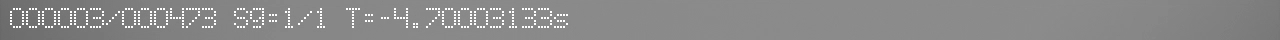

In [34]:
exp_folder = '6000cp_viscosity_standard_100fps'       
video_file_name = '6000cp_viscosity_standard_100fps.mp4'

caber.set_experiment_folder(exp_folder,video_file_name)
rotated_video_path=caber.rotate_kronos_video(f'{exp_folder}/{video_file_name}')
video=caber.pims.Video(rotated_video_path)
caber.check_framerate(video)

In [35]:
%matplotlib ipympl
bs = caber.bbox_select(video[1])

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Button(description='Disconnect mpl', style=ButtonStyle())

The frame size for reading (1024, 1280) is different from the source frame size (1280, 1024).


Frame([[[211, 211, 211],
        [204, 204, 204],
        [183, 183, 183],
        ...,
        [189, 189, 189],
        [206, 206, 206],
        [209, 209, 209]],

       [[211, 211, 211],
        [204, 204, 204],
        [183, 183, 183],
        ...,
        [189, 189, 189],
        [207, 207, 207],
        [210, 210, 210]],

       [[213, 213, 213],
        [204, 204, 204],
        [183, 183, 183],
        ...,
        [189, 189, 189],
        [207, 207, 207],
        [211, 211, 211]],

       ...,

       [[200, 200, 200],
        [182, 182, 182],
        [159, 159, 159],
        ...,
        [207, 207, 207],
        [207, 207, 207],
        [209, 209, 209]],

       [[200, 200, 200],
        [181, 181, 181],
        [158, 158, 158],
        ...,
        [206, 206, 206],
        [207, 207, 207],
        [209, 209, 209]],

       [[201, 201, 201],
        [182, 182, 182],
        [158, 158, 158],
        ...,
        [206, 206, 206],
        [207, 207, 207],
        [209, 209, 209]]], dtype=uint8)
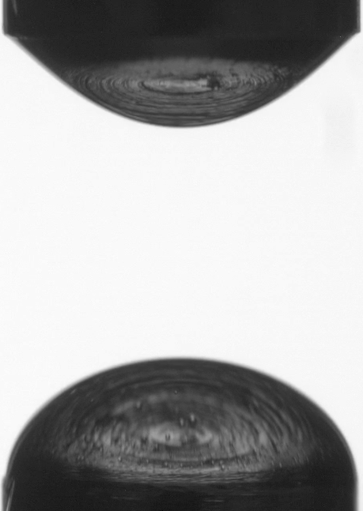

In [36]:
%matplotlib inline
mask=caber.get_mask_from_poly(bs)
video[-1][mask]

In [37]:
caber.find_thresh(video,-1,mask)

The frame size for reading (1024, 1280) is different from the source frame size (1280, 1024).


0.5775007604507258

In [38]:
result=caber.measure_neck(video,
                    caber.find_thresh(video,-3, mask), 
                    mask, 
                    strike_time=0.2,
                    mmperpix=6/(mask[1].stop-mask[1].start),
                    frame_rate=100)

IntProgress(value=0, description='6000cp_viscosity_standard_100fps/6000cp_viscosity_standard_100fps_rotated.mp…

The frame size for reading (1024, 1280) is different from the source frame size (1280, 1024).


327


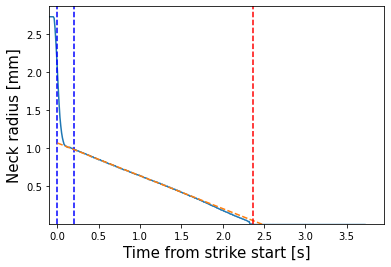

In [39]:
ax=caber.make_plot(result, fit_relax=True, min_radius=0.4)


IntProgress(value=0, layout=Layout(width='50%'), max=458)

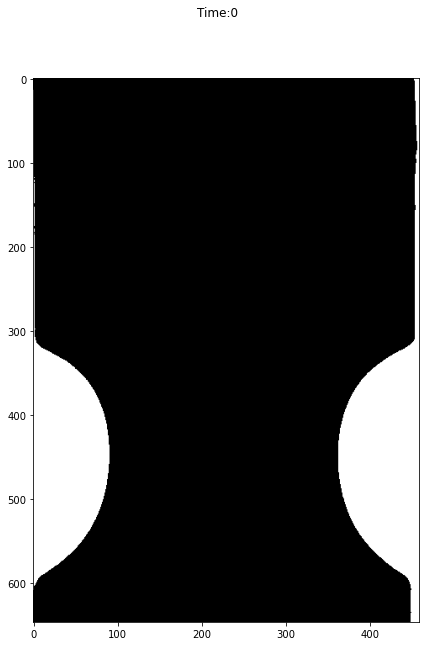

In [40]:
anim=caber.make_animation(result,100)

In [41]:
anim.save(exp_folder + '/BW_' + video_file_name)

IntProgress(value=0, layout=Layout(width='50%'), max=458)

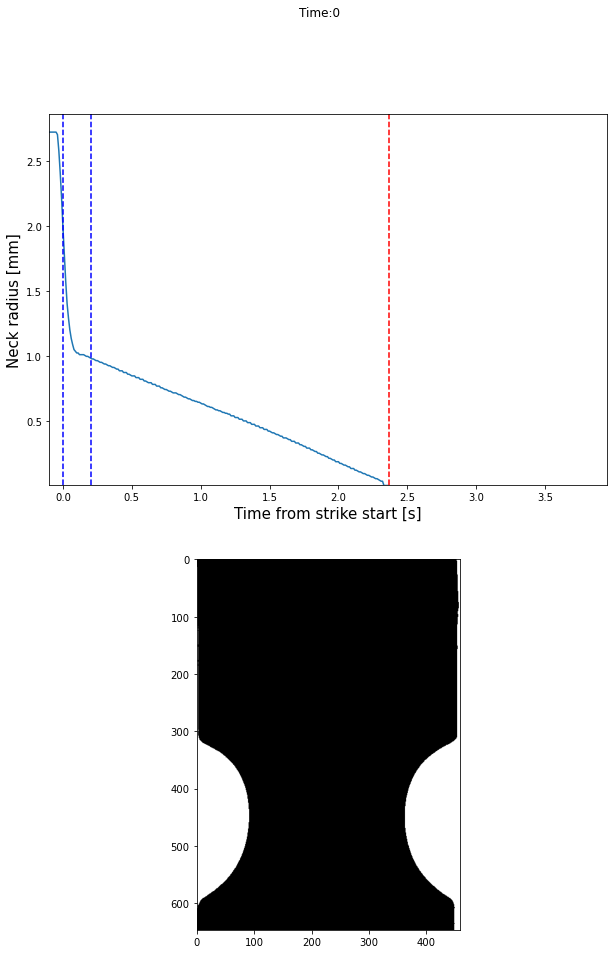

In [42]:
anim=caber.make_animation_withplot(result,100,min_radius=0.4)

In [43]:
anim.save(exp_folder + '/BWP_' + video_file_name)

In [44]:
import os
os.system('ffmpeg -i ' + exp_folder + '/BWP_' + video_file_name + ' -f gif ' + exp_folder + '/BWP_' + video_file_name.split('.')[0] + '.gif')

0

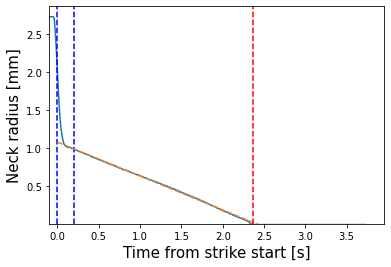

In [45]:
ax,fit_res=caber.make_plot(result, fit_relax=True, min_radius=0.01, model='newtonian')

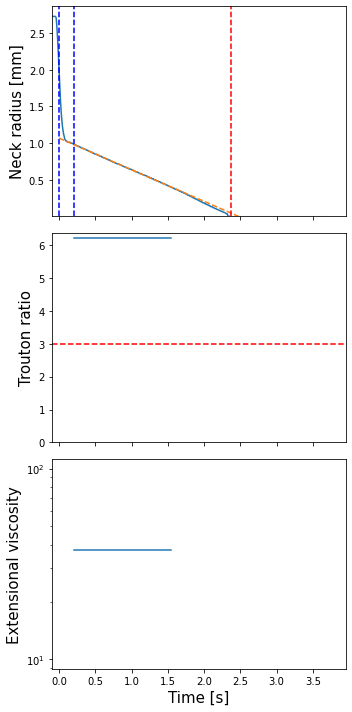

In [53]:
import matplotlib.pyplot as plt
import lmfit
import numpy as np
        
caber.rel_time(result, show_plot=True, ax=None, strike_time=0.2, min_radius=0.4, eta_0=6, surface_tension=30E-3)